<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/logistic_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from typing import Union, Optional
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined_ts.csv')
df.head()

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
0,1,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,...,0.129900,0.008119,0.358576,0.032100,0.001400,0.470588,0.000000,0.647059,0.941176,0.000
1,2,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,...,7.669778,0.365228,0.020237,-0.284889,3.335466,0.409091,-0.267421,0.363636,0.681818,0.150
2,3,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,...,7.508992,3.754496,0.666738,0.000840,37.494722,1.000000,-2.505261,0.666667,0.333333,-2.490
3,4,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,5,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,...,3.404658,0.162127,0.006660,0.000342,4.594823,0.409091,0.050000,0.045455,0.954545,0.085


In [4]:
df.shape

(13920, 25)

In [5]:
feature_list = list(set(df.columns) - set(['Address', 'Index', 'FLAG']))

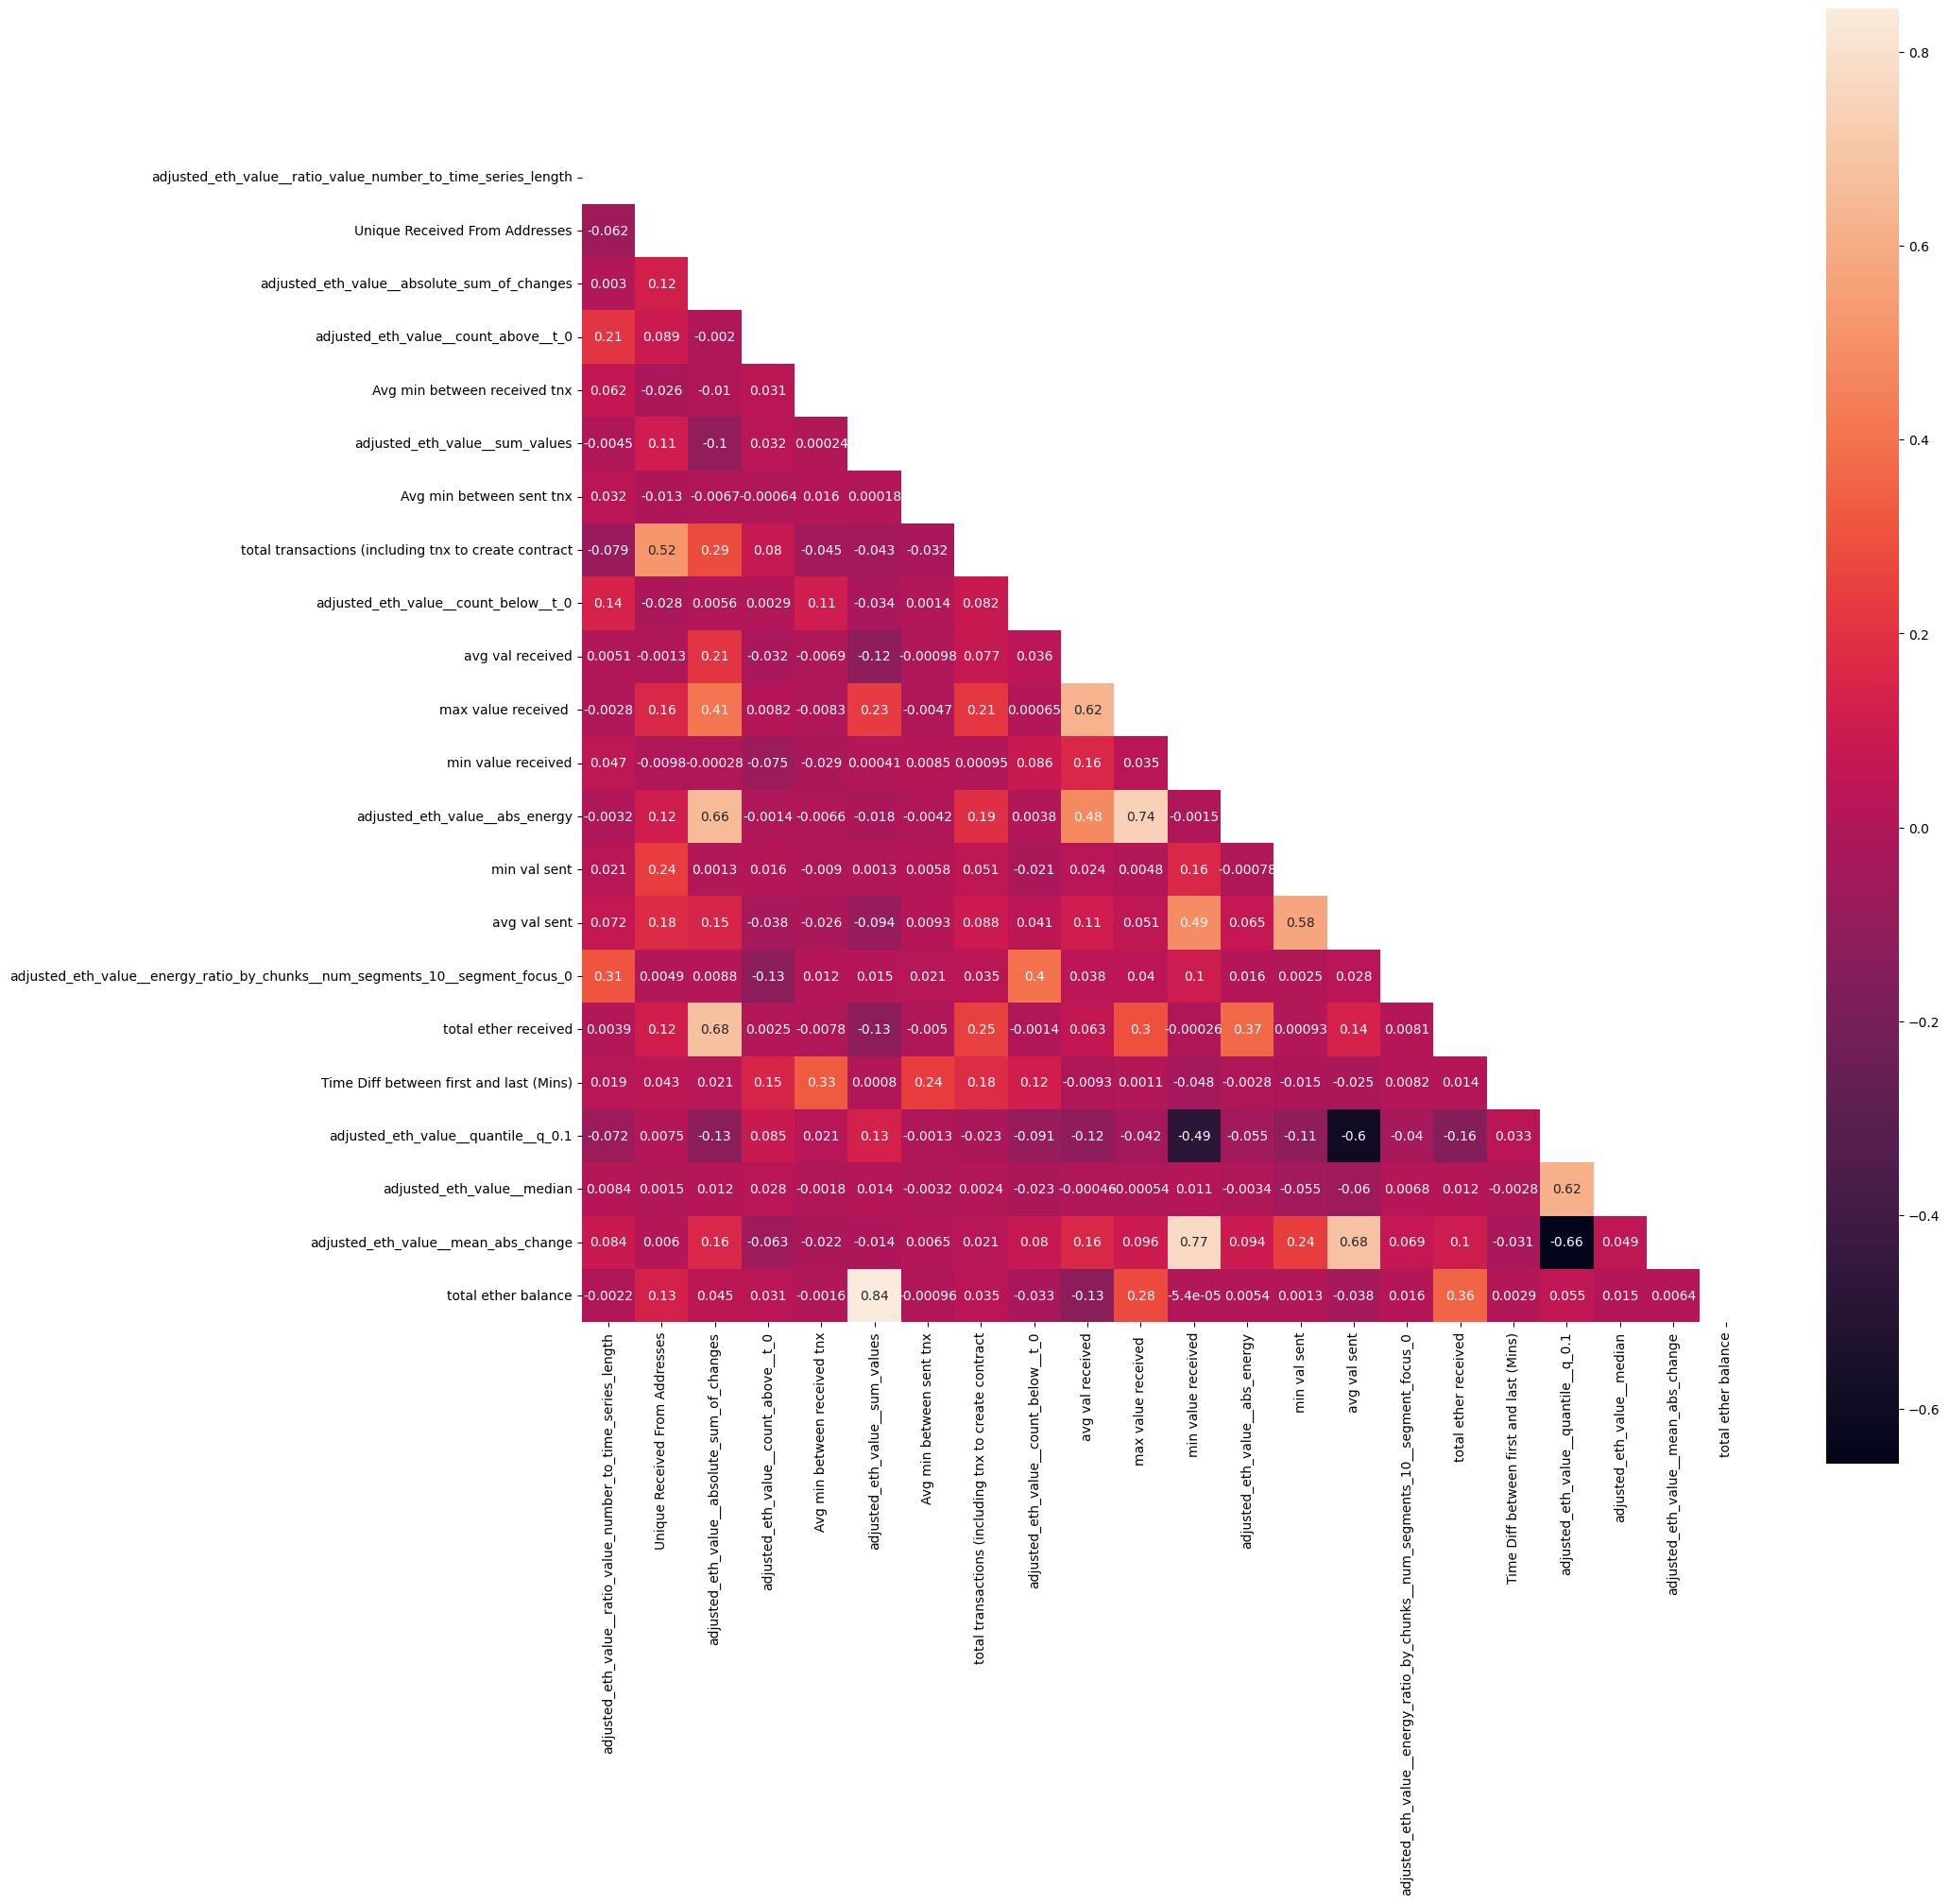

In [6]:
corr = df[list(set(feature_list))].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, square=True, annot=True)
plt.show()

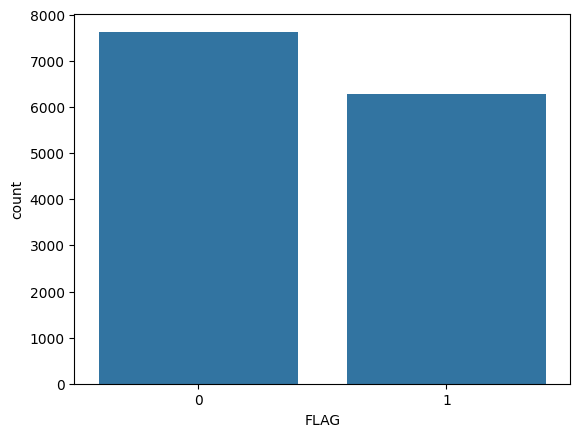

Target:  0.45136494252873566


In [7]:
sns.countplot(data=df, x='FLAG')
plt.show()
print('Target: ', df['FLAG'].mean())

In [8]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])
df_train.shape[0], df_test.shape[0]

(12528, 1392)

In [9]:
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=0, stratify=df_train['FLAG'])
df_train.shape[0], df_valid.shape[0]

(8769, 3759)

In [10]:
class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""

    def __init__(self, feature_list: list,
                 drop_feature_list: Optional[list] = None,
                 fillna: Union[int, str] = 0,
                 q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None):
        """
            `feature_list` - list with features name
            `drop_feature_list` - features to drop
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
        """
        self.feature_list = feature_list
        self.drop_feature_list = drop_feature_list
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers

    def fit(self, df):
        self.fillna_dict = {}
        self.q_up_dict = {}
        self.q_down_dict = {}

        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.feature_list:
                self.fillna_dict[feature] = 0
        else:
            for feature in self.feature_list:
                self.fillna_dict[feature] = None

        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                self.q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                self.q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)


        if self.drop_feature_list:
            self.feature_list = list(set(self.feature_list) - set(self.drop_feature_list))

        return self

    def transform(self, df):

        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)


        # numerical fillna
        for feature in self.feature_list:
            df.loc[df[feature].isna(), feature] = self.fillna_dict[feature]


        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] > self.q_up_dict[feature], feature] = self.q_up_dict[feature]

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] < self.q_down_dict[feature], feature] = self.q_down_dict[feature]


        return df

In [11]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median'
)

In [12]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [13]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [14]:
clf = LogisticRegression(max_iter=1000, random_state=0)
clf.fit(df_train_prep, df_train['FLAG'])

LogisticRegression(max_iter=1000, random_state=0)

In [15]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.8677172985228709
valid roc_auc_score:  0.8604356578363027
test roc_auc_score:  0.8626363090672624


### Without outliers

In [16]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median',
    q_up_clip_outliers=0.95,
    q_down_clip_outliers=0.05
)

In [17]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [18]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [19]:
clf = LogisticRegression(max_iter=1000, random_state=0)
clf = clf.fit(df_train_prep, df_train['FLAG'])

In [20]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.9275444022556947
valid roc_auc_score:  0.9284517894590042
test roc_auc_score:  0.937641728082169


In [21]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',              # metric for scoring
                   cv=10)                     # number of folds
clf.fit(df_train_prep, df_train['FLAG'])

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [22]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.9267356085289218
valid roc_auc_score:  0.9263598911069743
test roc_auc_score:  0.9361327408543703
